In [42]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import datetime
import pickle
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib as plt

In [2]:
promise_zone = gpd.read_file('../data/MDHA_Promise_Zones/Export_Output_5.shp')
print(promise_zone.crs)

epsg:2274


In [3]:
promise_zone = promise_zone.to_crs(epsg = 4326)

In [4]:
# Import the file as a Pandas DataFrame
fp = '../data/july.csv'
july = pd.read_csv(fp)

In [5]:
company_dict = {'Bird':0, 'Lyft': 1, 'Gotcha': 2, 'Lime': 3, 'Spin': 4, 'Jump': 5, 'Bolt': 6}
july.companyname = july.companyname.replace(company_dict)

In [6]:
july.pubdatetime = pd.to_datetime(july['pubdatetime'])

In [7]:
july.to_pickle("../data/july.pkl")

In [8]:
july_scooters = july[['pubdatetime', 'latitude', 'longitude', 'sumdid', 'chargelevel', 'companyname']]

In [9]:
july_scooters.tail()

,pubdatetime,latitude,longitude,sumdid,chargelevel,companyname
25075440,2019-07-31 23:59:57,36.162420,-86.779314,Powered-1a8321d0-5c21-04a4-bd7d-7b96ba51f17b,100.00,6
25075441,2019-07-31 23:59:57,36.146010,-86.810197,Powered-bd4ba83b-513f-ed5c-3c51-b4f51e7fdc51,100.00,6
25075442,2019-07-31 23:59:57,36.165837,-86.777765,Powered-cc9c0b7e-2b9e-def9-e48b-1a8a489c4daf,71.68,6
25075443,2019-07-31 23:59:57,36.149792,-86.806818,Powered-55a7ac02-7e17-bb3b-130d-b160d9776405,0.00,6
25075444,2019-07-31 23:59:57,36.162644,-86.779345,Powered-03be23ca-d43b-222f-be54-e44b5b4690df,100.00,6


In [10]:
july_scooters['geometry'] = july_scooters.apply(lambda x: Point((x.longitude,x.latitude)),
                                        axis=1)

C:\Users\RMAUR\AppData\Local\Temp/ipykernel_4336/1348184122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july_scooters['geometry'] = july_scooters.apply(lambda x: Point((x.longitude,x.latitude)),


In [11]:
july_scooters['day'] = july_scooters['pubdatetime'].dt.day


C:\Users\RMAUR\AppData\Local\Temp/ipykernel_4336/2140293322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july_scooters['day'] = july_scooters['pubdatetime'].dt.day


In [13]:
  july_scooters.head()

,pubdatetime,latitude,longitude,sumdid,chargelevel,companyname,geometry,day
0,2019-07-01 00:00:33.550,36.156678,-86.809004,Powered635135,22.0,1,POINT (-86.809004 36.156678),1
1,2019-07-01 00:00:34.973,36.145674,-86.794138,Powered790946,33.0,1,POINT (-86.794138 36.145674),1
2,2019-07-01 00:00:41.183,36.179319,-86.751538,Powered570380,76.0,1,POINT (-86.751538 36.179319),1
3,2019-07-01 00:00:41.620,36.152111,-86.803821,Powered240631,43.0,1,POINT (-86.803821 36.152111),1
4,2019-07-01 00:00:45.087,36.149355,-86.797550,Powered970404,52.0,1,POINT (-86.79755 36.149355),1


In [15]:
july_scooters = gpd.GeoDataFrame(july_scooters,crs=promise_zone.crs,geometry=july_scooters.geometry)

In [16]:
xmin, ymin, xmax, ymax = july_scooters.total_bounds

In [17]:
july_scooters = july_scooters[['pubdatetime', 'latitude', 'longitude', 'sumdid', 'geometry','day']]

In [18]:
july_scooters.head()

,pubdatetime,latitude,longitude,sumdid,geometry,day
0,2019-07-01 00:00:33.550,36.156678,-86.809004,Powered635135,POINT (-86.80900 36.15668),1
1,2019-07-01 00:00:34.973,36.145674,-86.794138,Powered790946,POINT (-86.79414 36.14567),1
2,2019-07-01 00:00:41.183,36.179319,-86.751538,Powered570380,POINT (-86.75154 36.17932),1
3,2019-07-01 00:00:41.620,36.152111,-86.803821,Powered240631,POINT (-86.80382 36.15211),1
4,2019-07-01 00:00:45.087,36.149355,-86.797550,Powered970404,POINT (-86.79755 36.14935),1


In [27]:
##creating grid shape

xmin, ymin, xmax, ymax = july_scooters.total_bounds

length = 1000
wide = 1200

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file("grid.shp")

In [26]:
grid.head()

,geometry
0,"POLYGON ((-97.444 0.000, 1102.556 0.000, 1102...."
1,"POLYGON ((-97.444 1000.000, 1102.556 1000.000,..."
2,"POLYGON ((-97.444 2000.000, 1102.556 2000.000,..."
3,"POLYGON ((-97.444 3000.000, 1102.556 3000.000,..."
4,"POLYGON ((-97.444 4000.000, 1102.556 4000.000,..."


In [29]:
promise_zone = promise_zone.to_crs(epsg = 3857)

In [54]:
polygon_zone_5 = promise_zone.loc[promise_zone['ZONE_ID']==5]

In [30]:
july_scooters = july_scooters.to_crs(epsg = 3857)

In [130]:
scooters_by_zone = gpd.sjoin( july_scooters,promise_zone, op = 'within')

C:\Users\RMAUR\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [131]:
scooters_by_zone.head()

,pubdatetime,latitude,longitude,sumdid,geometry,day,index_right,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe
0,2019-07-01 00:00:33.550,36.156678,-86.809004,Powered635135,POINT (-9663534.122 4322201.495),1,4,5,5,3.928178e+08,106661.712102
27,2019-07-01 00:00:59.040,36.171141,-86.790294,Powered162956,POINT (-9661451.334 4324195.734),1,4,5,5,3.928178e+08,106661.712102
83,2019-07-01 00:01:03.413,36.177049,-86.787551,Powered667863,POINT (-9661145.985 4325010.468),1,4,5,5,3.928178e+08,106661.712102
85,2019-07-01 00:01:03.723,36.174458,-86.785272,Powered084995,POINT (-9660892.287 4324653.153),1,4,5,5,3.928178e+08,106661.712102
126,2019-07-01 00:01:06.793,36.175679,-86.786034,Powered493869,POINT (-9660977.113 4324821.535),1,4,5,5,3.928178e+08,106661.712102


In [34]:
scoots_in_zone5 = scooters_by_zone.loc[scooters_by_zone['ZONE_ID']==5]

In [37]:
scoots_in_zone5 = scoots_in_zone5[['pubdatetime','sumdid','geometry','day','ZONE_ID']]

In [60]:
print(scoots_in_zone5.loc[scoots_in_zone5['sumdid'] == 'Powered667863'])

                     pubdatetime         sumdid  \
83       2019-07-01 00:01:03.413  Powered667863   
2659     2019-07-01 00:06:18.040  Powered667863   
5894     2019-07-01 00:11:05.823  Powered667863   
9434     2019-07-01 00:16:19.587  Powered667863   
12633    2019-07-01 00:21:07.667  Powered667863   
...                          ...            ...   
10675462 2019-07-13 12:18:58.720  Powered667863   
10678478 2019-07-13 12:24:13.123  Powered667863   
10681174 2019-07-13 12:29:00.963  Powered667863   
10684227 2019-07-13 12:34:16.010  Powered667863   
10686937 2019-07-13 12:39:02.740  Powered667863   

                                  geometry  day  ZONE_ID  
83        POINT (-9661145.985 4325010.468)    1        5  
2659      POINT (-9661147.432 4325012.675)    1        5  
5894      POINT (-9661148.434 4325010.606)    1        5  
9434      POINT (-9661148.656 4325014.881)    1        5  
12633     POINT (-9661146.652 4325011.709)    1        5  
...                              

In [119]:

xmin, ymin, xmax, ymax = scoots_in_zone5.total_bounds

length = 400
wide = 400

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

cell = gpd.GeoDataFrame(polygons, columns=['geometry'], 
                                 crs=promise_zone.crs)
grid.to_file("grid.shp")

(-9667399.200849514, -9659039.200849514, 4319894.199868959, 4333534.199868959)

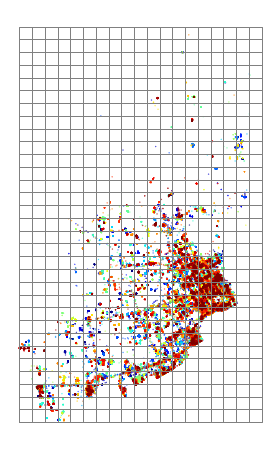

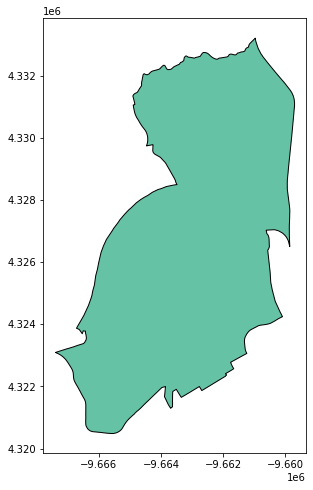

In [120]:
ax = scoots_in_zone5.plot(markersize=.1, figsize=(12, 8), column='day', cmap='jet')

polygon_zone_5.plot(column = 'ZONE_ID', figsize=(12, 8),
              edgecolor = 'black',
              cmap = 'Set2')

cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

In [121]:
zone_5_grid = gpd.sjoin( cell,polygon_zone_5, op = 'within')

C:\Users\RMAUR\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


(-9667381.106080059, -9659419.191008098, 4319906.89216885, 4333267.661571258)

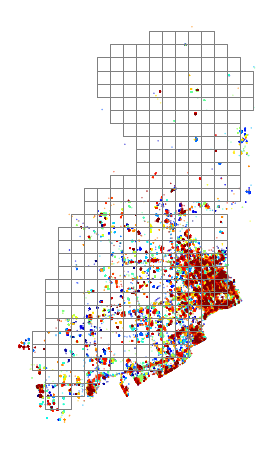

In [122]:
ax = scoots_in_zone5.plot(markersize=.1, figsize=(12, 8), column='day', cmap='jet')

zone_5_grid.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

In [123]:
merged = gpd.sjoin(scoots_in_zone5, cell, how='left', op='within')

C:\Users\RMAUR\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [124]:
# make a simple count variable that we can sum
merged['avg_scoots']=1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="mean")


In [126]:
merged.head()

,pubdatetime,sumdid,geometry,day,ZONE_ID,index_right,avg_scoots
0,2019-07-01 00:00:33.550,Powered635135,POINT (-9663534.122 4322201.495),1,5,252.0,1
27,2019-07-01 00:00:59.040,Powered162956,POINT (-9661451.334 4324195.734),1,5,412.0,1
83,2019-07-01 00:01:03.413,Powered667863,POINT (-9661145.985 4325010.468),1,5,445.0,1
85,2019-07-01 00:01:03.723,Powered084995,POINT (-9660892.287 4324653.153),1,5,475.0,1
126,2019-07-01 00:01:06.793,Powered493869,POINT (-9660977.113 4324821.535),1,5,475.0,1


In [144]:
by_sumdid = merged.groupby('sumdid')

In [145]:
by_sumdid.head()

,pubdatetime,sumdid,geometry,day,ZONE_ID,index_right,avg_scoots
0,2019-07-01 00:00:33.550,Powered635135,POINT (-9663534.122 4322201.495),1,5,252.0,1
27,2019-07-01 00:00:59.040,Powered162956,POINT (-9661451.334 4324195.734),1,5,412.0,1
83,2019-07-01 00:01:03.413,Powered667863,POINT (-9661145.985 4325010.468),1,5,445.0,1
85,2019-07-01 00:01:03.723,Powered084995,POINT (-9660892.287 4324653.153),1,5,475.0,1
126,2019-07-01 00:01:06.793,Powered493869,POINT (-9660977.113 4324821.535),1,5,475.0,1
...,...,...,...,...,...,...,...
25063527,2019-07-31 23:41:07.513,Powered3AMP6Z5DHO5B4,POINT (-9660881.935 4324134.507),31,5,NaN,1
25066722,2019-07-31 23:46:07.860,Powered3AMP6Z5DHO5B4,POINT (-9660888.280 4324164.155),31,5,NaN,1
25069793,2019-07-31 23:51:07.953,Powered3AMP6Z5DHO5B4,POINT (-9660894.848 4324161.122),31,5,NaN,1
25072904,2019-07-31 23:56:08.057,Powered3AMP6Z5DHO5B4,POINT (-9660882.269 4324162.225),31,5,NaN,1


In [ ]:
for day in merged['day']:
    for loc in merged['geometry']:
            merged.groupby('sumdid')

(-9667399.200849514, -9659039.200849514, 4319894.199868959, 4333534.199868959)

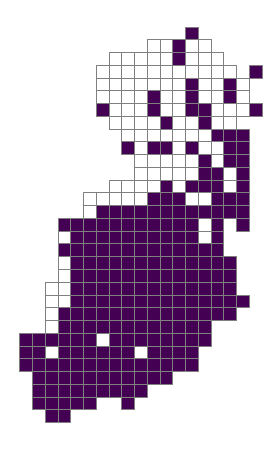

In [82]:
##Then finally let’s plot the grid and the avg scooters in each grid cell with geopandas:
ax = cell.plot(column='avg_scoots', figsize=(12, 8), cmap='viridis', vmax=5000, edgecolor="grey")

zone_5_grid.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")


In [142]:
scooters_by_zone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13188527 entries, 0 to 25075222
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   pubdatetime  datetime64[ns]
 1   latitude     float64       
 2   longitude    float64       
 3   sumdid       object        
 4   geometry     geometry      
 5   day          int64         
dtypes: datetime64[ns](1), float64(2), geometry(1), int64(1), object(1)
memory usage: 704.3+ MB


In [143]:
scooters_by_zone['lat_long'] = scooters_by_zone.pd.concat([latitude,longitude],axis=1)

AttributeError: 'GeoDataFrame' object has no attribute 'pd'